In [2]:
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# figure beautification
sns.set_theme(
    style='whitegrid',
    palette='deep',
    color_codes=True # access seaborn colors by changing matplotlib color shorthands
)
%config InlineBackend.figure_format = 'retina'

### Exploring

In [3]:
# load ice thickness and convert to ice volume
icevol = {}

dirs = ['reference', 'idealized_+4', 'idealized_+12', 'NorESM']
warming_scenarios = dirs[1:]

for w in dirs:
    data = np.load(f'{w}/simulation-data.npz')
    icevol[w] = np.sum(data['h'], axis=(1,2)) * 40 * 40 / 1e3

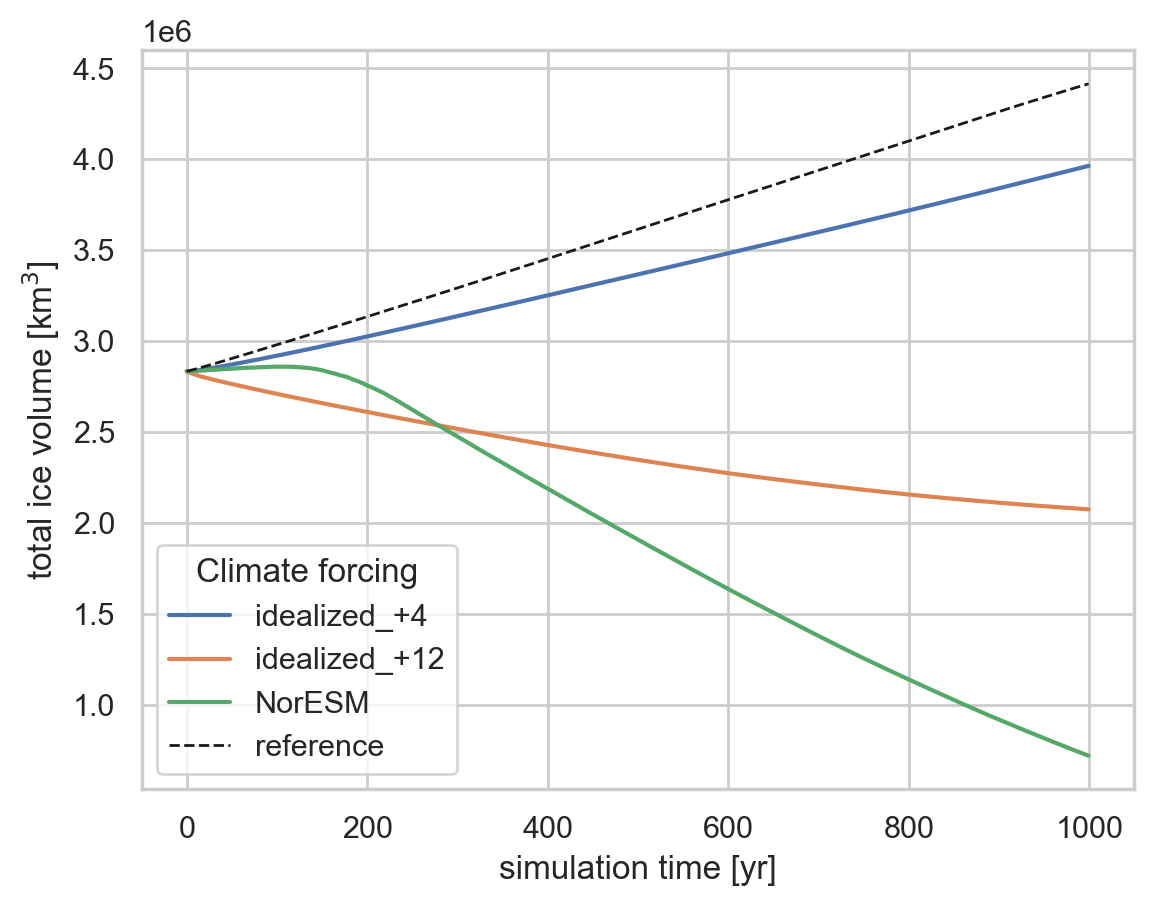

In [4]:
nyears = 1000

x = np.arange(nyears)

fig, ax = plt.subplots()
for w in warming_scenarios:
    ax.plot(x, icevol[w], label=w)
ax.plot(x, icevol['reference'], label='reference', ls='--', lw=1, color='k')

ax.legend(title='Climate forcing')
ax.set_xlabel('simulation time [yr]')
ax.set_ylabel(r'total ice volume [km$^3$]')
plt.savefig('figs/ice-volume.png', dpi=300, bbox_inches='tight')

### Sea-level contribution

In [5]:
# adjust ice volume: idealized -> to reference; realistic -> to present-day
# & drop idealized scenario, now, extreme scenario is the idealized scenario
icevol_adj = {}
icevol_adj['idealized_+4']  = icevol['idealized_+4']  - icevol['reference']
icevol_adj['idealized_+12'] = icevol['idealized_+12'] - icevol['reference']
icevol_adj['NorESM'] = icevol['NorESM'] - icevol['NorESM'][0]

In [6]:
# calculate ice loss rate
for w in warming_scenarios:
    print(f'{w}:\t{np.mean(np.gradient(icevol_adj[w]))} km^3/year')

idealized_+4:	-452.01898550693505 km^3/year
idealized_+12:	-2342.3162001868895 km^3/year
NorESM:	-2114.708616192999 km^3/year


In [7]:
# express ice volume as sea-level contribution
def volume_to_sealevel(icevol, rho=0.92):
    # input ice volume in km^3
    # (counted positively for loss)
    return (-1) * rho * icevol / 361e3

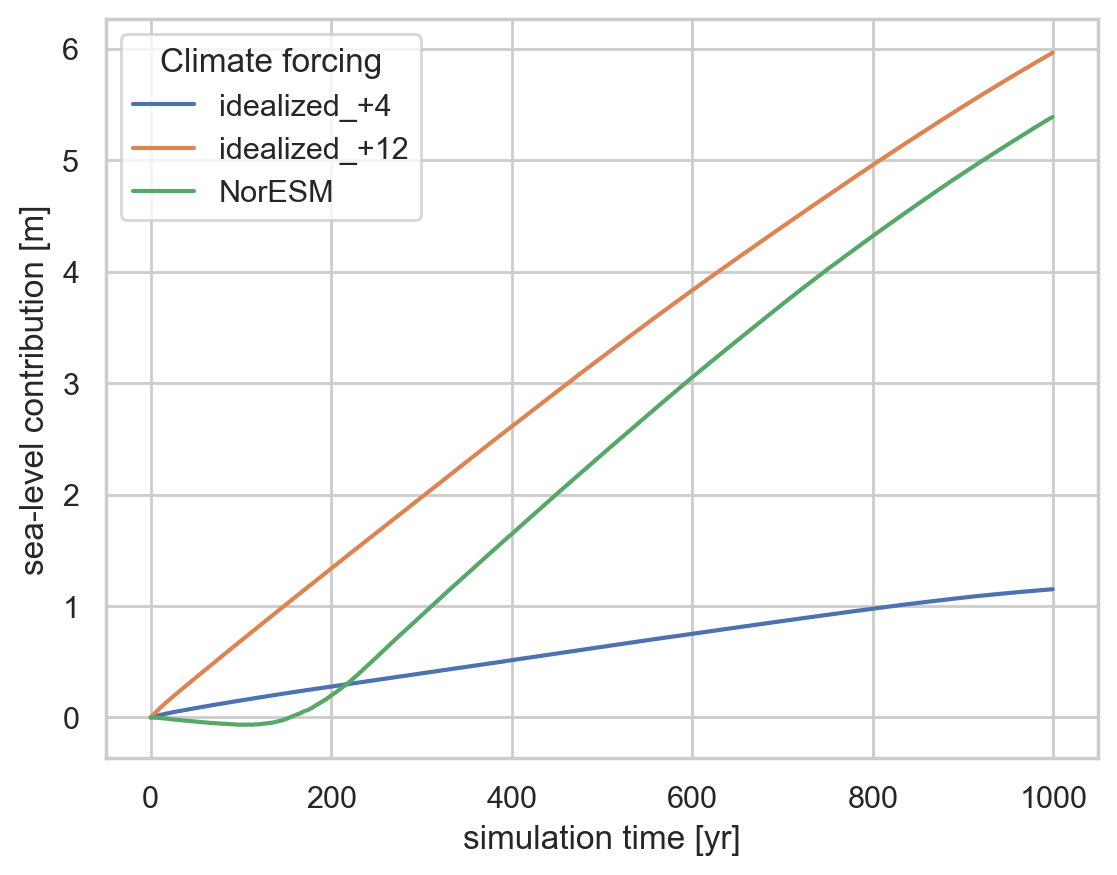

In [8]:
fig, ax = plt.subplots()

for w in warming_scenarios:
    ax.plot(x, volume_to_sealevel(icevol_adj[w]), label=w)

ax.set_xlabel('simulation time [yr]')
ax.set_ylabel('sea-level contribution [m]')
ax.legend(title='Climate forcing')

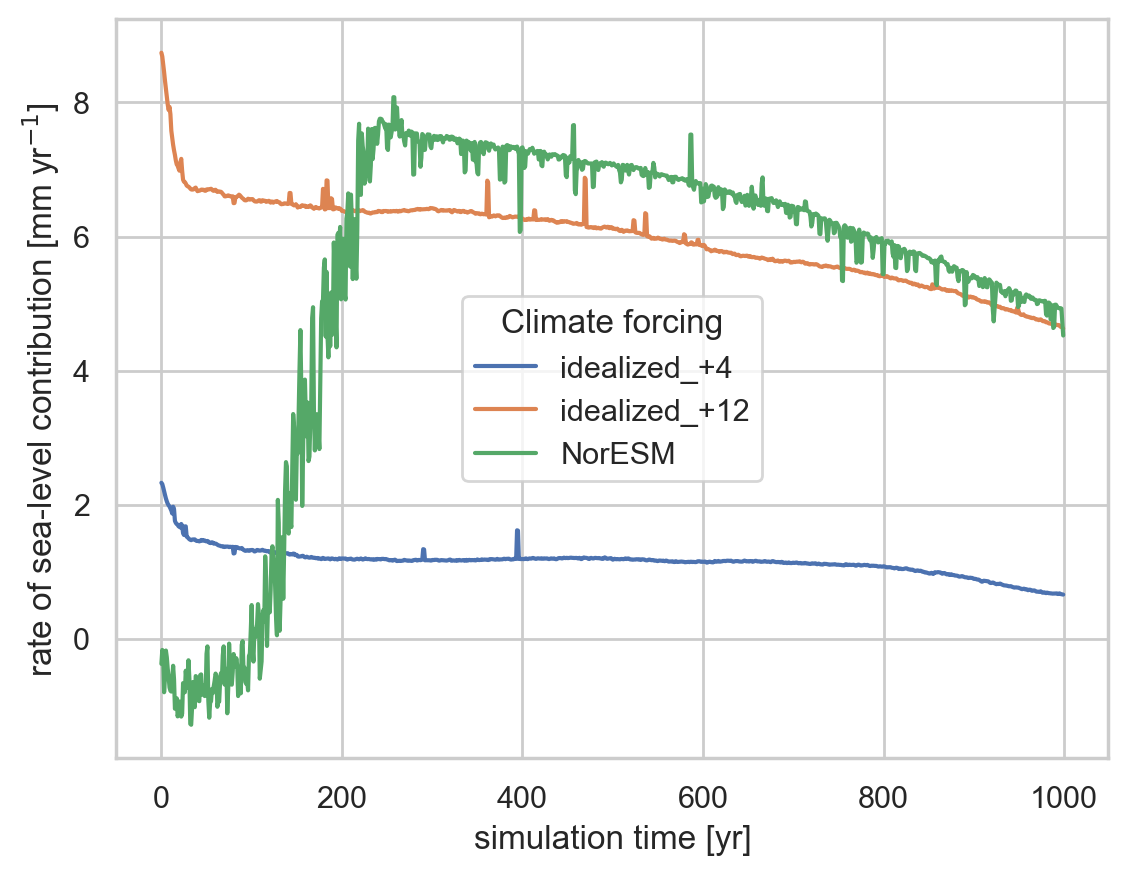

In [9]:
# plot map of rate of sea-level rise
fig, ax = plt.subplots()

for w in warming_scenarios:
    icevol_adj_rate = np.gradient(icevol_adj[w])
    ax.plot(x, volume_to_sealevel(icevol_adj_rate)*1e3, label=w)

ax.set_xlabel('simulation time [yr]')
ax.set_ylabel(r'rate of sea-level contribution [mm yr$^{-1}$]')
ax.legend(title='Climate forcing')

### Add ice thickness at 3000 CE to plot

In [10]:
# load ice thicknes
h = {}
for w in dirs:
    data = np.load(f'{w}/simulation-data.npz')
    h[w] = data['h']

    print(f'{w}:\t{np.max(h[w])}')

reference:	3766.5947252673973
idealized_+4:	3760.1266763359713
idealized_+12:	3502.2219481607735
NorESM:	3208.394197287848


In [11]:
xlon    = data['xlon']
ylat    = data['ylat']
seamask = data['seamask'][-1]
trans = ccrs.PlateCarree()
proj = ccrs.NorthPolarStereo(central_longitude=-44)
# add coastline of greenland
# get path to shapefile
shpfilename = shpreader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
# read shapefile
shpfile = shpreader.Reader(shpfilename)
# select greenland only
greenland = [country.geometry for country in shpfile.records() \
             if country.attributes["NAME_LONG"] == "Greenland"]

idealized_+4:	1.1504687897113022 m
idealized_+12:	5.9626532875321665 m
NorESM:	5.387212257290885 m


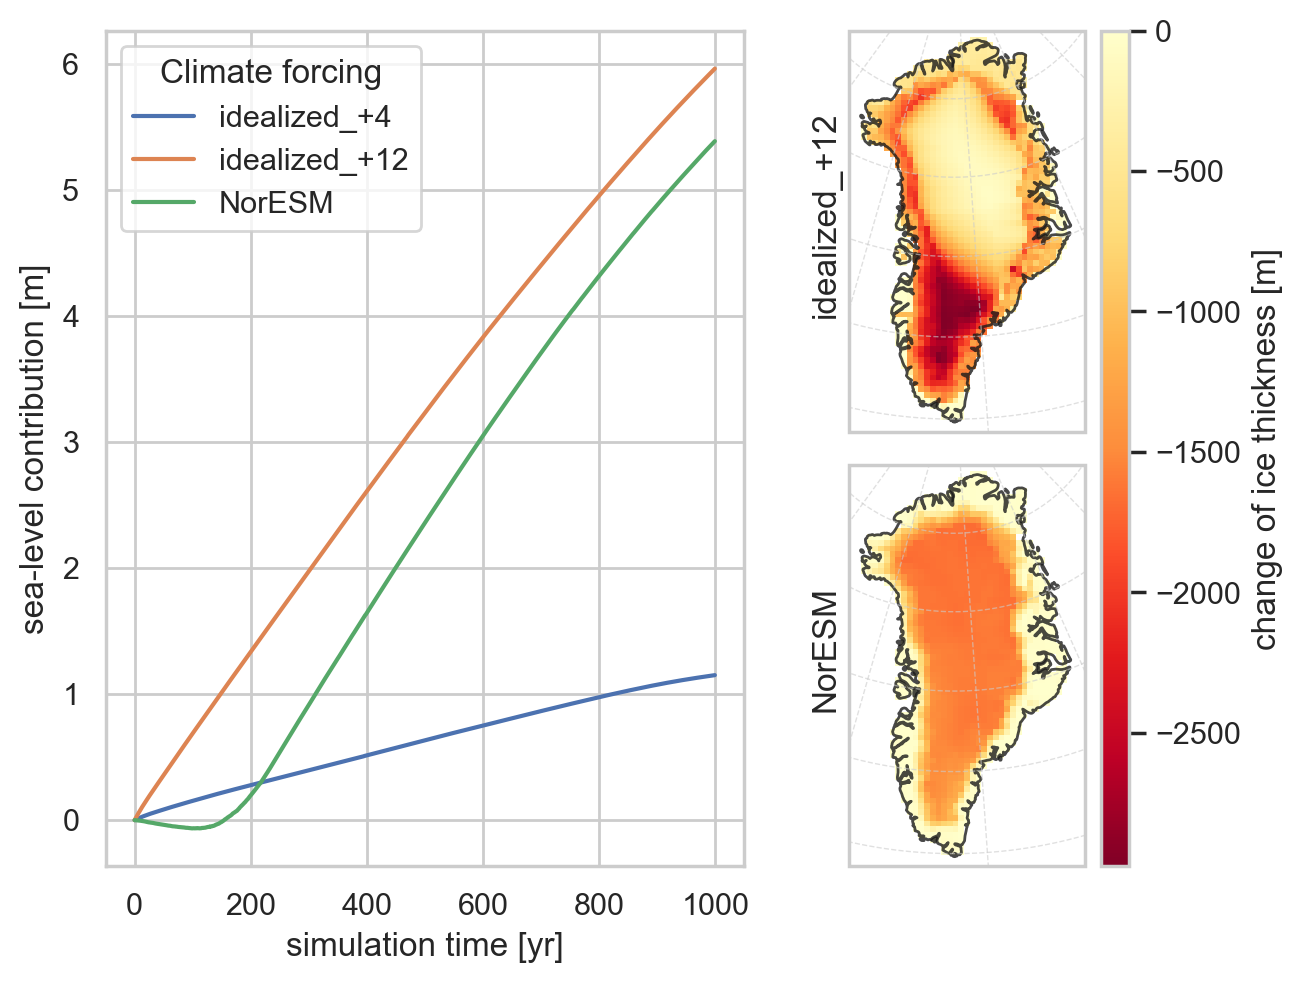

In [12]:
# create layout for subplots
fig = plt.figure(layout="constrained")
spec = fig.add_gridspec(2, 3)
ax = fig.add_subplot(spec[:, :2])
geo0 = fig.add_subplot(spec[0, 2], projection=proj)
geo1 = fig.add_subplot(spec[1, 2], projection=proj)

### plot graph of sea-level contribution ###
for w in warming_scenarios:
    ax.plot(x, volume_to_sealevel(icevol_adj[w]), label=w)
    print(f'{w}:\t{volume_to_sealevel(icevol_adj[w])[-1]} m')
ax.set_xlabel('simulation time [yr]')
ax.set_ylabel('sea-level contribution [m]')
ax.legend(title='Climate forcing')

#bounds = np.arange(0, 1501, 300)
#bounds = np.append(bounds, [2000, 2500, 3000, 3500])
#bounds = np.geomspace(.5, 3500, 25)
#norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
#norm = mpl.colors.LogNorm(vmax=np.max(h['extreme-warming']))

### plot maps of change in ice thickness ###
hchange = {}
hchange['idealized_+12'] = h['idealized_+12'][-1] - h['reference'][-1]
hchange['NorESM'] = h['NorESM'][-1] - h['NorESM'][0]
norm = mpl.colors.Normalize(vmin=np.min([hchange[w] for w in hchange.keys()]))
for i, w in enumerate(hchange.keys()):
    ax = [geo0, geo1][i]
    h_masked = np.ma.array(hchange[w], mask=seamask)
    cm = ax.pcolormesh(xlon, ylat, h_masked, cmap='YlOrRd_r', shading='nearest',
                       transform=trans, norm=norm)
    ax.set_title(w, rotation='vertical',x=-0.1,y=0.5, va='center')
    # add greenland coastline
    ax.add_geometries(greenland, crs=trans, fc='none', ec='k', alpha=0.8)
    ax.gridlines(alpha=.6, ls='--', lw=.5)
cbar = fig.colorbar(cm, ax=[geo0, geo1], aspect=30)
cbar.set_label('change of ice thickness [m]')
plt.savefig('figs/sea-level-contribution.png', dpi=300, bbox_inches='tight')

### Climate index

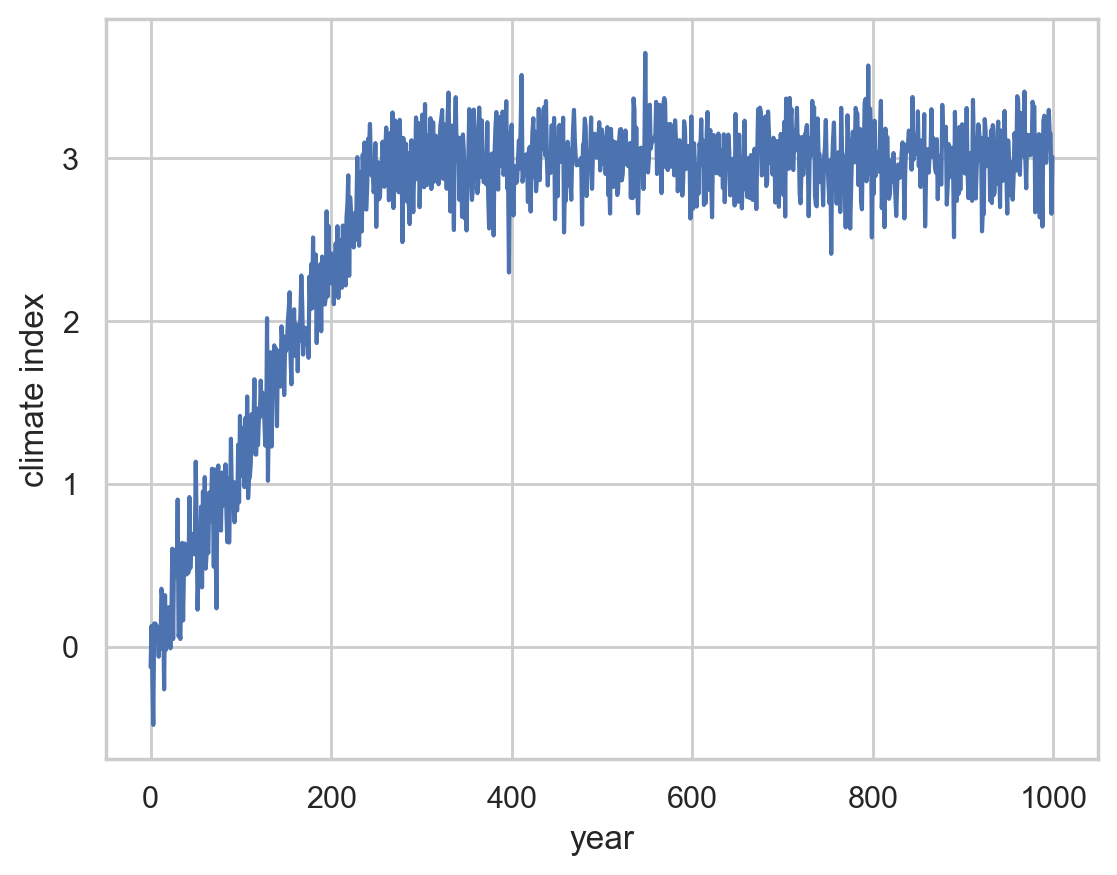

In [13]:
clim_index = np.load('../../model-input/climate_index.npy')
plt.plot(clim_index)
plt.xlabel('year')
plt.ylabel('climate index')
plt.savefig('figs/climate-index.png', dpi=300, bbox_inches='tight')

### Rate of ice loss

In [14]:
# calculate ice loss rate from ice thickness
# (no conversion as volume/mass plotted on map depends on grid box size)

# adjust idealistic scenario to reference
h_adj = {}
for w in ['idealized_+4', 'idealized_+12']:
    h_adj[w] = h[w] - h['reference']
h_adj['NorESM'] = h['NorESM'] - h['NorESM'][0]

iceloss = {}
for w in warming_scenarios:
    rate = np.empty((41, 70))
    for ilon in range(41):
        for jlat in range(70):
            rate[ilon,jlat] = np.mean(np.gradient(h_adj[w][:,ilon,jlat]))
    iceloss[w] = rate

In [15]:
print(warming_scenarios)
print([iceloss[w].max() for w in warming_scenarios])
print([iceloss[w].min() for w in warming_scenarios])

['idealized_+4', 'idealized_+12', 'NorESM']
[0.16615342398237318, 0.0, 0.0003001414671721596]
[-1.5785911163037047, -2.97937710676494, -1.695838713498743]


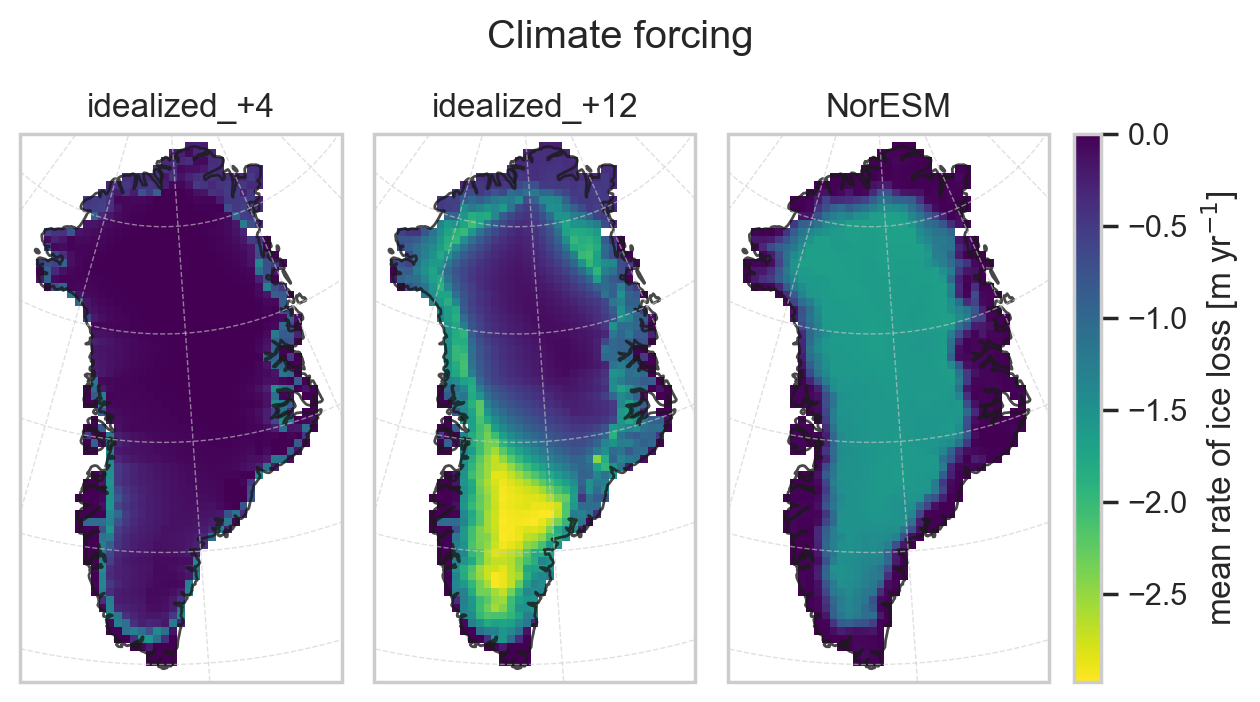

In [16]:
fig, axs = plt.subplots(1, 3, subplot_kw=dict(projection = proj),
                        figsize=(8,4), gridspec_kw=dict(wspace=.1))
norm = mpl.colors.Normalize(vmax=0, vmin=iceloss['idealized_+12'].min())
for ax, w in zip(axs, warming_scenarios):
    iceloss_masked = np.ma.array(iceloss[w], mask=seamask)
    cm = ax.pcolormesh(xlon, ylat, iceloss_masked, cmap='viridis_r',
                       shading='nearest', transform=trans, norm=norm)
    ax.set_title(w)
    # add greenland coastline
    ax.add_geometries(greenland, crs=trans, fc='none', ec='k', alpha=0.8)
    ax.gridlines(alpha=.6, ls='--', lw=.5)

cbar = fig.colorbar(cm, ax=axs, pad=.02, shrink=.89)
cbar.set_label(r'mean rate of ice loss [m yr$^{-1}$]')

fig.suptitle('Climate forcing')
plt.savefig('figs/ice-loss-rate.png', dpi=300, bbox_inches='tight')

In [18]:
iceloss['NorESM'][20, 35]

-1.5865013190215993